<a href="https://colab.research.google.com/github/RMilock/ComplexSpread/blob/main/MySpread_ver1.3.2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals:
* Create a regular squared graph and make the SIR dynamics evolve;
* Add nodes as in the Erdoes-Rényi model + SIR dynamic;
* Check at the S/N, I/N, R/N curves

todo: find the epidemic threshold of the disease

In [27]:
import random
import networkx as nx
#import networkx.generators.lattice as lattice
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product

# SIR on regular lattice

## Create a "small-world Poissonian Net" as described in the article
Note, that in the limit of $\langle k \rangle \ll N$, the probability of self-loops and parallels edges in small with $N$.
In fact, consider a graph with N nodes and to have for each node $k_i$ stubs, where $k_i$ is the $ith-$node degree. The probability to have a self-loop is basically $(k_i - 1) / N \sim O(1/N)$  and similarly for parallel edges.
 [link](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html)


      #look for adjacent nodes
      #for adj_node in G[node]:
          To find all edges add `node in G[adj_node] or`
          Now, only find several edges from the first to the adjacent node, 
          e.g. G[1] --> {..., 0: {0: {}, 1: {}},...} means 2 edges from 1 to 0
          #if node in G[adj_node] or len(G[node][adj_node]) > 1: 
          #    print(node, adj_node)

Degree sum: 17 with seed: 123
Degree sum: 13 with seed: 7
Degree sum: 20 with seed: 6

Network Created but w/o neighbors wiring!
Degree sum 20
0 {3: {0: {}, 1: {}}, 4: {0: {}}} 3
1 {} 0
2 {6: {0: {}, 1: {}}} 2
3 {0: {0: {}, 1: {}}} 2
4 {4: {0: {}}, 5: {0: {}}, 6: {0: {}}, 0: {0: {}}} 5
5 {4: {0: {}}, 5: {0: {}}} 3
6 {2: {0: {}, 1: {}}, 4: {0: {}}, 6: {0: {}}} 5
[(0, 3), (0, 3), (0, 4), (2, 6), (2, 6), (4, 4), (4, 5), (4, 6), (5, 5), (6, 6)] 
 2 [(0, 3), (2, 6)] 
 None
{1: 0, 2: 2, 3: 2, 0: 3, 5: 3, 4: 5, 6: 5}
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 0, 5, 4, 6]


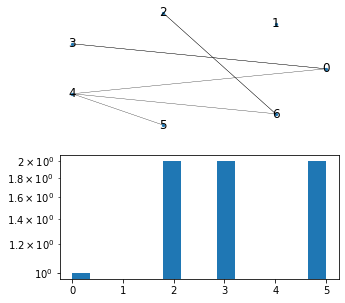

In [109]:
def nodes_adjac_degrees(G):
  print("Degree sum", np.sum([j for (i,j) in G.degree() ])  )
  for node in G.nodes(): 
      print(node, G[node], G.degree(node))

N = int(7); D = 2; p=0; seed=123; np.random.seed(seed)

'''create a network with the node degrees drawn from a poissonian with even sum of degrees'''
degrees = np.random.poisson(D,N) #for def of poissonian distr degrees are integers
print("Degree sum:", np.sum(degrees), "with seed:", seed)
while(np.sum(degrees)%2!=0): #i.e. sum is odd --> change seed
  seed=int(np.random.random_sample()*10)
  np.random.seed(seed)
  degrees = np.random.poisson(D,N)
  print("Degree sum:", np.sum(degrees), "with seed:", seed, )

print("\nNetwork Created but w/o neighbors wiring!")
G = nx.configuration_model(degrees)

'''check graphical modification wrt the imposed degree'''
repetita = [x for n, x in enumerate([y for y in G.edges()]) if x in [y for y in G.edges()][:n]]
print(G.edges(), "\n", len(repetita), repetita, "\n", nodes_adjac_degrees(G))

'''plot it togheter with the probability distribution'''
fig, axs = plt.subplots(2,1, figsize=(5,5))
nx.draw_circular(G, ax=axs[0], with_labels=True, font_size=12, node_size=5, width=.3)
_ = axs[1].hist(degrees, bins=14, density=False, log=True)

''' start of the PLAYGROUND CELL here only for convenience '''
######PLAYGROUND CELL
nodes_degree = {}
for node in G.nodes():
  nodes_degree[node] = G.degree(node)
sorted_nodes_degree = {k: v for k, v in sorted(nodes_degree.items(), key=lambda item: item[1])}
sorted_nodes = [node for node in sorted_nodes_degree.keys()]

'''remove all edges but list all nodes to be used for wiring'''
ebunch = [x for x in G.edges()]
G.remove_edges_from(ebunch)
l_nodes = [x for x in G.nodes()]

print(sorted_nodes_degree); print(l_nodes); print(sorted_nodes);

Sort nodes by ascending degree, connect to neighbors and cancel that node from the list of nodes to prevent future rewiring. Repeat this since "error rises"

TO DO:
* if len(l_nodes)==1: break
* remove loops

In [110]:
try:
  edges = set() #avoid to put same link twice (+ unordered)
  #print(nodes_adjac_degrees(G))
  print(sorted_nodes, sorted_nodes_degree.values())

  for node in sorted_nodes:
    print(node, degrees[node], l_nodes)

    '''create edges rewiring from ascending degree'''
    for j in range(1,degrees[node]//2+1): #neighbors attachment and no self-loops "1"
        print("entered for j:",j)
        idx = l_nodes.index(node)
        print("idx:", idx)
        a_attached = l_nodes[(idx+j)%N] #anticlockwise-linked node
        c_attached = l_nodes[idx-j]
        print(node,a_attached); print(node,c_attached);
        if node != a_attached and degrees[node]!=0: G.add_edge(node,a_attached); degrees[a_attached]-=1; \
        print("deg[%s] = %s" % (a_attached, degrees[a_attached]))

        if node != c_attached and degrees[node]!=0: G.add_edge(node,c_attached); degrees[c_attached]-=1; \
        print("deg[%s] = %s"%(c_attached,degrees[c_attached]))
    
    '''degrees[i] is odd, then, +1 anticlock-wise'''
    if degrees[node]%2 != 0: aa_attached = l_nodes[(idx-degrees[node]//2+1)%N]; \
                            G.add_edge(node, aa_attached); degrees[aa_attached]-=1; print(node, aa_attached); print("deg[%s] = %s"%(aa_attached,degrees[aa_attached]))
    l_nodes.remove(node)

except:
  G.remove_edges_from(nx.selfloop_edges(G))
   

[1, 2, 3, 0, 5, 4, 6] dict_values([0, 2, 2, 3, 3, 5, 5])
1 0 [0, 1, 2, 3, 4, 5, 6]
2 2 [0, 2, 3, 4, 5, 6]
entered for j: 1
idx: 1
2 3
2 0
deg[3] = 1
deg[0] = 2
3 1 [0, 3, 4, 5, 6]
3 4
deg[4] = 4
0 2 [0, 4, 5, 6]
entered for j: 1
idx: 0
0 4
0 6
deg[4] = 3
deg[6] = 4
5 3 [4, 5, 6]
entered for j: 1
idx: 1
5 6
5 4
deg[6] = 3
deg[4] = 2
5 5
deg[5] = 2
4 2 [4, 6]
entered for j: 1
idx: 0
4 6
4 6
deg[6] = 2
deg[6] = 1
6 1 [6]


IndexError: ignored

In [53]:
######PLAYGROUND CELL
nodes_degree = {}
for node in G.nodes():
  nodes_degree[node] = G.degree(node)
print(nodes_degree, {k: v for k, v in sorted(nodes_degree.items(), key=lambda item: item[1])})

ebunch = [x for x in G.edges()]
G.remove_edges_from(ebunch)
l_nodes = [x for x in G.nodes()]

edges = set() #avoid to put same link twice (+ unordered)
print(nodes_adjac_degrees(G))
print(degrees)
for i in range(N):
    for j in range(1,degrees[i]//2+1): #neighbors attachment and no self-loops "1"
        if i != l_nodes[(i+j)%N]: G.add_edge(i,l_nodes[(i+j)%N]); print(i,l_nodes[(i+j)%N])
        if i != l_nodes[i-j]:  G.add_edge(i,l_nodes[i-j]); print(i,l_nodes[i-j])
    
    '''degrees[i] is odd, then, +1 anticlock-wise'''
    if degrees[i]%2 != 0: G.add_edge(i,l_nodes[i-(degrees[i]//2)-1])
    print(i, G.degree(i))
    #if len(edges)!=np.sum(degrees)/2: break


#for i,j in product(range(N), repeat=2):
#  if i != j and random.random() <= p: # with this meth we have 2p of chance of edging. So, the mean=n*2p
#    edges.add((i,j))

#G.add_edges_from(edges)
repetita = [x for n, x in enumerate([y for y in G.edges()]) if x in [y for y in G.edges()][:n]]
print(G.edges(), "\n", len(repetita), repetita, "\n", nodes_adjac_degrees(G))

'''plot it togheter with the probability distribution'''
fig, axs = plt.subplots(2,1, figsize=(5,5))
nx.draw_circular(G, ax=axs[0], with_labels=True, font_size=12, node_size=5, width=.3)
_ = axs[1].hist(degrees, 14, density=False, log=True)

NameError: ignored

In [ ]:
#### OLD ONE


ebunch = [x for x in G.edges()]
G.remove_edges_from(ebunch)
l_nodes = [x for x in G.nodes()]

edges = set() #avoid to put same link twice (+ unordered)
print(nodes_adjac_degrees(G))

for i in range(N):
    for j in range(1,degrees[i]//2+1): #neighbors attachment and no self-loops "1"
        if i != l_nodes[(i+j)%N]: edges.add((i,l_nodes[(i+j)%N]))
        if i != l_nodes[i-j]:  edges.add((i,l_nodes[i-j]))
    
    '''degrees[i] is odd, then, +1 anticlock-wise'''
    if degrees[i]%2 != 0: edges.add((i,l_nodes[i-(degrees[i]//2)-1]))
    print(G.degree)
    #if len(edges)!=np.sum(degrees)/2: break


#for i,j in product(range(N), repeat=2):
#  if i != j and random.random() <= p: # with this meth we have 2p of chance of edging. So, the mean=n*2p
#    edges.add((i,j))

G.add_edges_from(edges)
repetita = [x for n, x in enumerate([y for y in G.edges()]) if x in [y for y in G.edges()][:n]]
print(G.edges(), "\n", len(repetita), repetita, "\n", nodes_adjac_degrees(G))

'''plot it togheter with the probability distribution'''
fig, axs = plt.subplots(2,1, figsize=(5,5))
nx.draw_circular(G, ax=axs[0], with_labels=True, font_size=12, node_size=5, width=.3)
_ = axs[1].hist(degrees, 14, density=False, log=True)

1) `for j in range(1,degrees[i]//2+1): #neighbors attachment and no self-loops
      if i != l_nodes[(i+j)%N]: edges.add((i,l_nodes[(i+j)%N]))
      if i != l_nodes[i-j]:  edges.add((i,l_nodes[i-j]))`

with this part i'm rewiring twice the neighbors. It's possible to think to a solution where if already an edge exists may be skipped;

2) Consider the Newman algorithm, where new edge are added when the rewiring is at work. In WS-model the edge are actively changed and not added;

3)TODO: create a net s.t. that all links will be present twice, i.e. (0,1) and (1,0)

## Create a squared lattice

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20,10))


def rgraph(N,p):
    G = nx.Graph()

    'Center the initial squared lattice'
    pos = {0:(0,0),1:(1,0),2:(1,1),3:(0,1)}#dict with two of the positions set
    for i in range(4,N): pos[i]=(random.random()+(-1)**random.randint(0,1), random.random()+(-1)**random.randint(0,1) )

    'Add nodes to graph and "double"-edging'
    G.add_nodes_from(pos.keys())
    for n, coord in pos.items():
      G.nodes[n]['pos'] = coord
    edges = set() #avoid to put same link twice (unordered). (0,1) and (1,0) are allowed
    for i,j in product(range(4), repeat=2):
      if j==(i+1)%4 or j==(i-1)%4: edges.add((i,j))
    for i,j in product(range(N), repeat=2):
      if i != j and random.random() <= p: # since i,j "run freely", we have 2p of chance of edging. So, the mean=n*2p
        edges.add((i,j))

    'Remove the cross edges within the square'
    disclist=[(0,2),(2,0),(1,3),(3,1)]
    for x in disclist: edges.discard(x)
    G.add_edges_from(edges)
    print(G.edges())

    return G,pos

G,pos=rgraph(8,0.1)

nx.draw(G, ax=axs[0], pos=pos, with_labels=True, font_size=12, node_size=5, width=.3)


def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    axs[1].hist(degrees, bins="auto", log=False, density=0)
plot_degree_dist(G)

## Make the disease spread

In [ ]:
def sir(G,beta,mu):
    'Number of nodes in the graph'
    N=G.number_of_nodes()
    
    'Label the individual wrt to the # of the node'
    node_labels = G.nodes()
    
    'Currently infected individuals and the future infected and recovered' 
    inf_list = [] 
    prevalence = []
    recovered = []

    'Initial Conditions'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    'Selects the seed of the disease'
    seed = random.choice(range(N)) 
    current_state[seed] = 'I'
    future_state[seed] = 'I'
    inf_list.append(seed)    
   

    while(len(inf_list)>0):        
        
        'Infection Phase: each infected tries to infect all of the neighbors'
        for i in inf_list:
            'Select the neighbors of the infected node'
            tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
            for j in tests:
                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    if random.random() < beta:
                        future_state[j] = 'I'
                    else:
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            if random.random() < mu:
                future_state[i] = 'R'
            else:
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
       
        'Updates inf_list with the currently fraction of inf/rec' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'
        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))

        
    return prevalence, recovered

In [ ]:
plt.figure(figsize=(10,5))

beta = 0.04 # infection probability
mu = 0.05 # recovery probability

# simulate SIR dynamics and obtain prevalence
prevalence, recovered = sir(G, beta, mu)

plt.plot(prevalence, label="Infected/N")
plt.plot(recovered, label="Recovered/N")

plt.xlabel('Time', fontsize = 16)
plt.ylabel('Indivs/N', fontsize = 16)
plt.legend(loc="best");

In [ ]:
#todo:
L=len(prevalence)

def mov_avg(a):
    p=[a[0]]
    for i in range(1,L): 
      if i <=7:  tmp=a[i-1]+(a[i]-a[i-1])/i; p.append(tmp); print(p[i],i)
      elif i>7: tmp=1/7*(a[i]+7*p[i-1]-a[i-1]); p.append(tmp)
    return p

plt.plot(mov_avg(prevalence), label="Mov_Avg_Inf/N")